## This version is an update to #11 but includes additional components from the AC Becker debrief (sum bases to zero, etc.)

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd
from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
x = np.arange(-16, 16, 1)
y = x.copy()
y0, x0 = np.meshgrid(x, y)
grid = np.dstack((y0, x0))
print x0.shape

(32, 32)


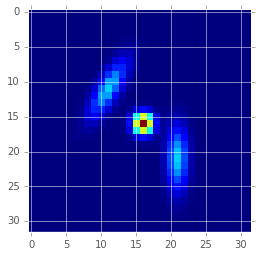

In [3]:
import scipy.stats

## see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html

def gaussian2d(grid, m=None, s=None):
    if m is None:
        m = [0., 0.]
    if s is None:
        s = [1., 1.]
    cov = [[s[0], 0], [0, s[1]]]
    var = scipy.stats.multivariate_normal(mean=m, cov=cov)
    return var.pdf(grid)

def singleGaussian2d(x, y, xc, yc, sigma_x=1., sigma_y=1., theta=0., offset=0.):
    theta = (theta/180.) * np.pi
    cos_theta2, sin_theta2 = np.cos(theta)**2., np.sin(theta)**2.
    sigma_x2, sigma_y2 = sigma_x**2., sigma_y**2.
    a = cos_theta2/(2.*sigma_x2) + sin_theta2/(2.*sigma_y2)
    b = -(np.sin(2.*theta))/(4.*sigma_x2) + (np.sin(2.*theta))/(4.*sigma_y2)
    c = sin_theta2/(2.*sigma_x2) + cos_theta2/(2.*sigma_y2)
    xxc, yyc = x-xc, y-yc
    out = np.exp( - (a*(xxc**2.) + 2.*b*xxc*yyc + c*(yyc**2.)))
    if offset != 0.:
        out += offset
    out /= out.sum()
    return out

#x, y = np.mgrid[-15:16:1, -15:16:1]
#grid = np.dstack((x, y))
#g1 = gaussian2d(grid) + gaussian2d(grid, [5,5], [3,1]) + gaussian2d(grid, [-5,-5], [3., 1.], rot=30.)
g1 = singleGaussian2d(x0, y0, 0, 0, 1, 1) + singleGaussian2d(x0, y0, 5, 5, 3, 1) + \
        singleGaussian2d(x0, y0, -5, -5, 3, 1, theta=30.)
plt.imshow(g1, interpolation='none')

## Update: it looks like the actual code in the stack uses chebyshev1 polynomials!

Note these are essentially the same but with different scale factors.

In [4]:
# This code works, but I think the next cell is faster.
from numpy.polynomial.chebyshev import chebgrid2d

h0 = chebgrid2d(x, y, c=[[1, 0, 0], [1, 0, 0]])
h1 = chebgrid2d(x, y, c=[[0, 1, 0], [0, 1, 0]])
h2 = chebgrid2d(x, y, c=[[1, 0, 0], [0, 1, 0]])
h3 = chebgrid2d(x, y, c=[[0, 1, 0], [0, 0, 1]])

In [5]:
from numpy.polynomial.chebyshev import chebval2d
h0 = chebval2d(x0, y0, c=[[1, 0, 0], [1, 0, 0]])
h1 = chebval2d(x0, y0, c=[[0, 1, 0], [0, 1, 0]])
h2 = chebval2d(x0, y0, c=[[1, 0, 0], [0, 1, 0]])
h3 = chebval2d(x0, y0, c=[[0, 1, 0], [0, 0, 1]])

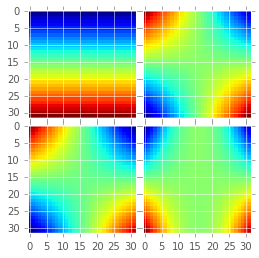

In [6]:
fig = plt.figure(1, (4., 4.))
igrid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
igrid[0].imshow(h0, interpolation='none')  # The AxesGrid object work as a list of axes.
igrid[1].imshow(h1, interpolation='none')  # The AxesGrid object work as a list of axes.
igrid[2].imshow(h2, interpolation='none')  # The AxesGrid object work as a list of axes.
igrid[3].imshow(h3, interpolation='none')  # The AxesGrid object work as a list of axes.

In [7]:
## The following code does exactly the same as the above:
from numpy.polynomial.chebyshev import chebval
def chebval2d_try(x, y, xord, yord):
    cx = chebval(x, xord)
    cy = chebval(y, yord)
    h0 = np.outer(cx, cy)
    return h0

if False:
    #h0 = chebval2d_try(x, y, [1, 0, 0], [0, 1, 0])
    h0 = chebval2d_try(x, y, [0, 1, 0], [0, 1, 0])
    #h0 = chebval2d_try(x, y, [0, 1, 0], [0, 0, 1])
    print h0.shape
    plt.imshow(h0)

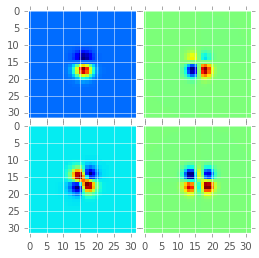

In [8]:
gh0 = gaussian2d(grid, s=[3., 3.]) * h0
gh1 = gaussian2d(grid, s=[3., 3.]) * h1
gh2 = gaussian2d(grid, s=[3., 3.]) * h2
gh3 = gaussian2d(grid, s=[3., 3.]) * h3
fig = plt.figure(1, (4., 4.))
igrid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
extent = (x0.min(), x0.max(), y0.min(), y0.max())
igrid[0].imshow(gh0, interpolation='none')  # The AxesGrid object work as a list of axes.
igrid[1].imshow(gh1, interpolation='none')  # The AxesGrid object work as a list of axes.
igrid[2].imshow(gh2, interpolation='none')  # The AxesGrid object work as a list of axes.
igrid[3].imshow(gh3, interpolation='none')  # The AxesGrid object work as a list of axes.

## Generate AL basis funcs now...

use same parameters as from the stack.

TBD: is a degGauss of 2 mean it goes up to order 2 (i.e. $x^2$)? Or is it 2 orders so it only goes up to linear ($x$)? Probably the former, so that's what we'll use.

In [9]:
# Parameters from stack
# betaGauss is actually the scale factor for sigGauss -> sigGauss[0] = sigGauss[1]/betaGauss and
#   sigGauss[2] = sigGauss[1] * betaGauss. Looks like here, betaGauss is 2 (see sigGauss below) but
#   we'll just set it to 1.
# Note should rescale sigGauss so sigGauss[1] = sqrt(sigma_I^2 - sigma_T^2)
betaGauss = 1   # in the Becker et al. paper betaGauss is 1 but PSF is more like 2 pixels?
sigGauss = [0.75, 1.5, 3.0]
degGauss = [4, 2, 2]
# Parameters from and Becker et al. (2012)
#sigGauss = [0.75, 1.5, 3.0]
degGauss = [6, 4, 2]

## Here beta is a rescale factor but this is NOT what it is really used for.
# Can be used to rescale so that sigGauss[1] = sqrt(sigmaPsf_I^2 - sigmaPsf_T^2)
def chebGauss2d(x, y, grid, m=None, s=None, ord=[0,0], beta=1., verbose=False):
    if m is None:
        m = [0., 0.]
    if s is None:
        s = [1., 1.]
    cov = [[s[0], 0], [0, s[1]]]
    coefLen = np.max(ord)+1
    coef0 = np.zeros(coefLen)
    coef0[ord[0]] = 1
    coef1 = np.zeros(coefLen)
    coef1[ord[1]] = 1
    if verbose:
        print s, ord, coef0, coef1
    ga = gaussian2d(grid, m, np.array(s)/beta)
    ch = chebval2d(x, y, c=np.outer(coef0, coef1))
    return ch * ga

In [10]:
basis = [chebGauss2d(x0, y0, grid, m=[0,0], s=[sig0,sig1], ord=[deg0,deg1], beta=betaGauss, verbose=False) for i0,sig0 in enumerate(sigGauss) for i1,sig1 in enumerate(sigGauss) for deg0 in range(degGauss[i0]) for deg1 in range(degGauss[i1])]
print len(basis), basis[0].shape, x0.shape, grid.shape, basis[0].reshape(x0.shape).shape

def get_valid_inds(Nmax):
    tmp = np.add.outer(range(Nmax+1), range(Nmax+1))
    return np.where(tmp <= Nmax)

inds = [get_valid_inds(i) for i in degGauss]
for i in inds:
    print i
basis = [chebGauss2d(x0, y0, grid, m=[0,0], s=[sig,sig], ord=[inds[i][0][ind], inds[i][1][ind]], beta=betaGauss, verbose=False) for i,sig in enumerate(sigGauss) for ind in range(len(inds[i][0]))]
print len(basis), basis[0].shape, x0.shape, grid.shape, basis[0].reshape(x0.shape).shape

144 (32, 32) (32, 32) (32, 32, 2) (32, 32)
(array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4,
       4, 4, 5, 5, 6]), array([0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 0, 1, 2, 3, 0,
       1, 2, 0, 1, 0]))
(array([0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4]), array([0, 1, 2, 3, 4, 0, 1, 2, 3, 0, 1, 2, 0, 1, 0]))
(array([0, 0, 0, 1, 1, 2]), array([0, 1, 2, 0, 1, 0]))
49 (32, 32) (32, 32) (32, 32, 2) (32, 32)


Make the two "images". `im1` is the template, `im2` is the science image.

NOTE: having sources near the edges really messes up the fitting (probably because of the convolution). So make sure no sources are near the edge.

NOTE: also it seems that having the variable source with a large flux increase also messes up the fitting (seems to lead to overfitting -- perhaps to the source itself). This might be fixed by adding more constant sources.

In [11]:
np.random.seed(66)

xim = np.arange(-256, 256, 1)
yim = xim.copy()
y0im, x0im = np.meshgrid(xim, yim)
imgrid = np.dstack((y0im, x0im))
n_sources = 500
fluxes = np.random.uniform(50, 30000, n_sources)
xposns = np.random.uniform(xim.min()+16, xim.max()-5, n_sources)
yposns = np.random.uniform(yim.min()+16, yim.max()-5, n_sources)

# Make the source closest to the center of the image the one that increases in flux
ind = np.argmin(xposns**2. + yposns**2.)
print ind, xposns[ind], yposns[ind]

sig1 = 0.2  # sigma of template
sig2 = 0.2  # sigma of science image
im1 = np.random.normal(scale=sig1, size=x0im.shape)
im2 = np.random.normal(scale=sig2, size=x0im.shape)

psf1 = 1.6 # sigma in pixels im1 will be template
psf2 = 2.2 # sigma in pixels im2 will be science image. make the psf in this image slighly offset and elongated
print np.sqrt(psf2**2 - psf1**2)
offset = 0.2  # astrometric offset (pixels) between the two images
psf2_yvary = 0.2 + (yim.mean() - yposns) / yim.max() * 0.2  # variation in y-width of psf in science image across (x-dim of) image
#psf2_yvary[:] = 1.1  # turn it off for now, just add a constant 1.1 pixel horizontal width
print scipy.stats.describe(psf2 + psf2_yvary)

for i in range(n_sources):
    flux = fluxes[i]
    im1 += flux * singleGaussian2d(x0im, y0im, xposns[i], yposns[i], psf1, psf1)
    if i == ind:
        flux += flux / 50.
    im2 += flux * singleGaussian2d(x0im, y0im, xposns[i]+offset, yposns[i]+offset, psf2, psf2+psf2_yvary[i], theta=45.)

# Add a (constant, for now) background offset to im2
im2background = 10.
im2 += im2background

print im1.shape
print scipy.stats.describe(im2 - im1, axis=None)

280 4.81591183536 -5.87310921947
1.50996688705
DescribeResult(nobs=500, minmax=(2.2049562670911143, 2.5876354349605717), mean=2.3964324010482767, variance=0.011661872337299909, skewness=-0.04897768964986584, kurtosis=-1.1235450782033973)
(512, 512)
DescribeResult(nobs=262144, minmax=(-1210.2847792403768, 316.28842436640252), mean=10.000018018197297, variance=3198.590152448442, skewness=-7.462414096630387, kurtosis=80.5095071804147)


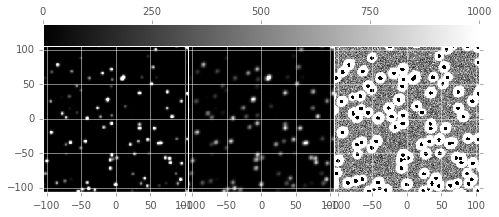

In [12]:
fig = plt.figure(1, (9, 3))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 3), axes_pad=0.0, share_all=True, label_mode="L",
                    cbar_location="top", cbar_mode="single")
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
gim = igrid[0].imshow(im1[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-0.1,1000))
igrid[1].imshow(im2[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(im2background-0.1,im2background+1000))
igrid[2].imshow((im2-im1)[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(im2background-1,im2background+1))
igrid.cbar_axes[0].colorbar(gim)

Convolve im1 (template) with the basis functions, and make these the *new* bases.

In [26]:
import scipy.signal

#print [np.abs(b).sum() for b in basis]
#print [(b/(b.max()-b.min()+1.)).sum() for b in basis]
#basis2 = [scipy.signal.fftconvolve(im1, b, mode='same') for b in basis]

for i in range(1, len(basis)):
    basis[i] -= basis[0]

basis2 = [scipy.ndimage.filters.convolve(im1, b, mode='constant') for b in basis]

print len(basis2), basis2[0].shape

49 (512, 512)


(array([0, 0, 0, 1, 1, 2]), array([0, 1, 2, 0, 1, 0]))
49 245
(array([0, 0, 0, 1, 1, 2]), array([0, 1, 2, 0, 1, 0]))
6 1.0


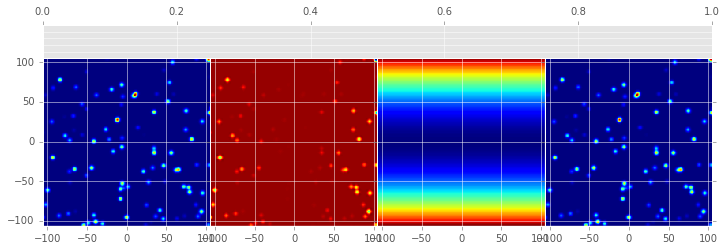

In [37]:
# Then make the spatially modified basis by simply multiplying the constant
#  basis (basis2 from above) by a polynomial along the image coordinate.
# Note that since we *are* including i=0, this new basis *does include* basis2 and
# thus can replace it.

## Here beta is a rescale factor but this is NOT what it is really used for.
# Can be used to rescale so that sigGauss[1] = sqrt(sigmaPsf_I^2 - sigmaPsf_T^2)

# Apparently the stack uses a spatial kernel order of 2? (2nd-order?)
spatialKernelOrder = 2  # 0
# Same for background order.
spatialBackgroundOrder = 2

def cheb2d(x, y, ord=[0,0], verbose=False):
    coefLen = np.max(ord)+1
    coef0 = np.zeros(coefLen)
    coef0[ord[0]] = 1
    coef1 = np.zeros(coefLen)
    coef1[ord[1]] = 1
    if verbose:
        print ord, coef0, coef1
    ch = chebval2d(x, y, c=np.outer(coef0, coef1))
    return ch

spatialBasis = bgBasis = None

def get_valid_inds(Nmax):
    tmp = np.add.outer(range(Nmax+1), range(Nmax+1))
    return np.where(tmp <= Nmax)

spatialInds = get_valid_inds(spatialKernelOrder)
print spatialInds

# Note the ordering of the loop is important! Make the basis2 the last one so the first set of values
# that are returned are all of the original (basis2) unmodified bases.
# Store "spatialBasis" which is the kernel basis and the spatial basis separated so we can recompute the
# final kernel at the end. Include in index 2 the "original" kernel.
if spatialKernelOrder > 0:
    spatialBasis = [[basis2[bi], cheb2d(x0im, y0im, ord=[spatialInds[0][i], spatialInds[1][i]], verbose=False), basis[bi]] for i in range(1,len(spatialInds[0])) for bi in range(len(basis2))]
    #basis2m = [b * cheb2d(x0im, y0im, ord=[spatialInds[0][i], spatialInds[1][i]], verbose=False) for i in range(1,len(spatialInds[0])) for b in basis2]
    print len(basis2), len(spatialBasis)

fig = plt.figure(1, (12, 4))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.0, share_all=True, label_mode="L",
                    cbar_location="top", cbar_mode="single")
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
gim = igrid[0].imshow(basis2[0][x1d:x2d,y1d:y2d], origin='lower', interpolation='none', extent=extent)
if spatialBasis is not None:
    igrid[1].imshow((spatialBasis[64][0]*spatialBasis[64][1])[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', extent=extent)

spatialBgInds = get_valid_inds(spatialBackgroundOrder)
print spatialBgInds
    
# Then make the spatial background part
if spatialBackgroundOrder > 0:
    bgBasis = [cheb2d(x0im, y0im, ord=[spatialBgInds[0][i], spatialBgInds[1][i]], verbose=False) for i in range(len(spatialBgInds[0]))]
    print len(bgBasis), bgBasis[0].mean()

igrid[2].imshow(bgBasis[5][x1d:x2d,y1d:y2d], origin='lower', interpolation='none', extent=extent)
if spatialBasis is not None:
    igrid[3].imshow(spatialBasis[0][0][x1d:x2d,y1d:y2d], origin='lower', interpolation='none', extent=extent)

In [79]:
# Collect the bases into a single matrix
# ITMT, let's make sure all the bases are on a reasonable scale.

basis2a = np.vstack([b.flatten() for b in basis2]).T
#print len(basis2), basis2a.shape, im2.flatten().shape
print scipy.stats.describe(basis2a, None)

constKernelIndices = np.arange(0, basis2a.shape[1])
print constKernelIndices

nonConstKernelIndices = None
if spatialBasis is not None:
    b1 = np.vstack([(b[0]*b[1]).flatten() for b in spatialBasis]).T
    print scipy.stats.describe(b1, None)
    nonConstKernelIndices = np.arange(basis2a.shape[1], basis2a.shape[1]+b1.shape[1])
    basis2a = np.hstack([basis2a, b1])
    print nonConstKernelIndices

bgIndices = None
if bgBasis is not None:
    b1 = np.vstack([b.flatten() for b in bgBasis]).T
    print scipy.stats.describe(b1, None)
    bgIndices = np.arange(basis2a.shape[1], basis2a.shape[1]+b1.shape[1])
    basis2a = np.hstack([basis2a, b1])
    print bgIndices

# Rescale the bases so that the "standard" A&L linear fit will work (i.e. when squared, not too large!)
print scipy.stats.describe(basis2a, None)
basisOffset = 0. #basis2a.mean(0) + 0.1  # avoid division by zero
basisScale = basis2a.std(0) + 0.1
basis2a = (basis2a-basisOffset)/(basisScale)
print scipy.stats.describe(basis2a, None)

DescribeResult(nobs=12845056, minmax=(-34821.561671923067, 168353.38197168728), mean=202.64681028986934, variance=7346833.0253306357, skewness=20.20606273081147, kurtosis=544.9019679970835)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]
DescribeResult(nobs=64225280, minmax=(-5943594475.4045534, 16736435914.290009), mean=3215667.136468403, variance=8451431688355450.0, skewness=45.93865644960672, kurtosis=3278.233145556746)
[ 49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102
 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120
 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138
 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156
 157 158 159 160 161 162 163 164 

Do the linear fit to compute the matching kernel. This is NOT the same fit as is done by standard A&L but gives the same results. This will not work for very large images. See below. The resulting fit is the matched template.

1457.68054001
-391.321267181
0.999356760723
[ 11462.55130073] 11462.5513007 864702512.801
DescribeResult(nobs=262144, minmax=(-0.897797108955805, 4.6255454436717685), mean=-2.7581030111168379e-12, variance=0.043726329906632479, skewness=0.4541800697514564, kurtosis=7.393511115933649)


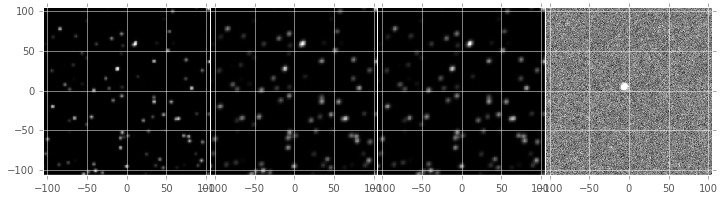

In [80]:
pars, resid, _, _ = np.linalg.lstsq(basis2a, im2.flatten())
print np.sum(pars[constKernelIndices])
if nonConstKernelIndices is not None:
    print np.sum(pars[nonConstKernelIndices])
if bgIndices is not None:
    print np.sum(pars[bgIndices])
fit = (pars * basis2a).sum(1).reshape(im2.shape)
print resid, np.sum((im2 - fit.reshape(im2.shape))**2), np.sum((im2 - im1)**2)
#print basis2a.shape, fit.shape

fig = plt.figure(1, (12, 3))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.0)
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
gim = igrid[0].imshow(im1[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[1].imshow(fit[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[2].imshow(im2[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[3].imshow((im2 - fit)[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-1,1))
#igrid.cbar_axes[0].colorbar(gim)
print scipy.stats.describe(im2 - fit, axis=None)

Look at the resulting matching kernel by multiplying the fitted parameters times the original basis funcs. and test that actually convolving it with the template gives us a good subtraction.

Here, we'll just compute the spatial part at x,y=0,0 (i.e. x,y=256,256 in img coords)

1.00002813263 8.7731850236e-11
1.00002813271


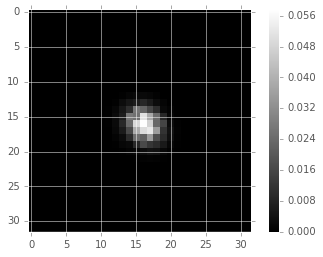

In [100]:
kbasis1 = np.vstack([b.flatten() for b in basis]).T
kbasis1 = (kbasis1 - basisOffset) / basisScale[constKernelIndices]
kfit1 = (pars[constKernelIndices] * kbasis1).sum(1).reshape(basis[0].shape)

kbasis2 = np.vstack([(b[2]*b[1][256, 256]).flatten() for b in spatialBasis]).T
kbasis2 = (kbasis2 - basisOffset) / basisScale[nonConstKernelIndices]
kfit2 = (pars[nonConstKernelIndices] * kbasis2).sum(1).reshape(basis[0].shape)

print kfit1.sum(), kfit2.sum()
kfit = kfit1 + kfit2
print kfit.sum()
kfit /= kfit.sum()  # this is necessary if the variable source changes a lot - prevent the kernel from incorporating that change in flux
plt.imshow(kfit, interpolation='none', cmap='gray')  # this plots the matching kernel
plt.colorbar()

Compare the convolved template to the science image. Also plot the new diffim for comparison.

DescribeResult(nobs=262144, minmax=(-45.315259727425428, 81.116933224753325), mean=10.00020119228061, variance=12.051682385477122, skewness=1.136472350170121, kurtosis=55.11983961225789)


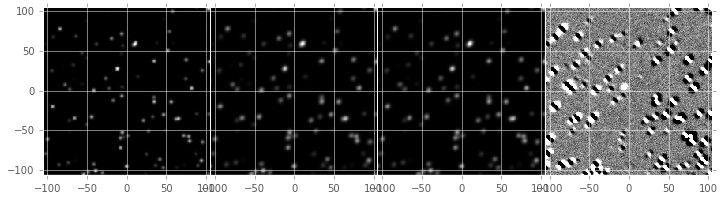

In [101]:
conv_im1 = scipy.ndimage.filters.convolve(im1, kfit, mode='constant')
fig = plt.figure(1, (12, 3))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.0)
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
gim = igrid[0].imshow(im1[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent) # original template (red)
igrid[1].imshow(conv_im1[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent) # convolved template (blue)
igrid[2].imshow(im2[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent) # science image (dotted, purple)
igrid[3].imshow((im2 - conv_im1)[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(im2background-1,im2background+1)) # diffim (grey)
print scipy.stats.describe(im2 - conv_im1, axis=None)

Create the $b_i$ and $M_{ij}$ from the A&L (1998) and Becker (2012) papers. This was done wrong in the previous version of notebook 3 (and above), although it gives identical results.

1106.32924739
2150.91678662
0.999699073061
[] 11462.5513007 864702512.801
DescribeResult(nobs=262144, minmax=(-0.90016915431619005, 4.6247690435461379), mean=1.7328138706904084e-12, variance=0.04373036508861318, skewness=0.45393414631543116, kurtosis=7.389585440831359)


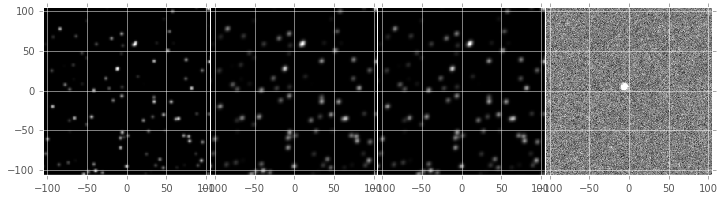

In [90]:
b = (basis2a.T * im2.flatten()).sum(1)
M = np.dot(basis2a.T, basis2a)

pars2, resid, _, _ = np.linalg.lstsq(M, b)
print np.sum(pars2[constKernelIndices])
if nonConstKernelIndices is not None:
    print np.sum(pars2[nonConstKernelIndices])
if bgIndices is not None:
    print np.sum(pars2[bgIndices])

#print 'Difference (log10):\n', np.log10(np.abs((pars2-pars)/pars2))

fit2 = (pars2 * basis2a).sum(1).reshape(im1.shape)
#print basis2a.shape, fit2.shape
print resid, np.sum((im2 - fit.reshape(im2.shape))**2), np.sum((im2 - im1)**2)

fig = plt.figure(1, (12, 3))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.0)
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
gim = igrid[0].imshow(im1[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[1].imshow(fit2[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[2].imshow(im2[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[3].imshow((im2 - fit2)[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-1,1))
#igrid.cbar_axes[0].colorbar(gim)
print scipy.stats.describe(im2 - fit2, axis=None)

1.00003132212 4.49471319864e-10
1.00003132257


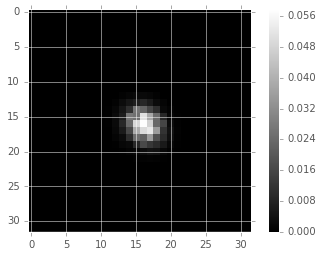

In [87]:
kbasis1 = np.vstack([b.flatten() for b in basis]).T
kbasis1 = (kbasis1 - basisOffset) / basisScale[constKernelIndices]
kfit1 = (pars2[constKernelIndices] * kbasis1).sum(1).reshape(basis[0].shape)

kbasis2 = np.vstack([(b[2]*b[1][256,256]).flatten() for b in spatialBasis]).T
kbasis2 = (kbasis2 - basisOffset) / basisScale[nonConstKernelIndices]
kfit2 = (pars2[nonConstKernelIndices] * kbasis2).sum(1).reshape(basis[0].shape)

print kfit1.sum(), kfit2.sum()
kfit = kfit1 + kfit2
print kfit.sum()
kfit /= kfit.sum()  # this is necessary if the variable source changes a lot - prevent the kernel from incorporating that change in flux
plt.imshow(kfit, interpolation='none', cmap='gray')  # this plots the matching kernel
plt.colorbar()

(512, 512) -0.150478282306 1474.86672662
DescribeResult(nobs=262144, minmax=(4.6742963527504811e-06, 1464789.2468609277), mean=3298.5783111596029, variance=791431313.70675993, skewness=17.061223903109088, kurtosis=381.21669752109375)
DescribeResult(nobs=262144, minmax=(4.043961121067293e-06, 6579.9741611110167), mean=112.05577330475914, variance=15021.393655264112, skewness=17.71133382833447, kurtosis=479.6280638199053)
DescribeResult(nobs=262144, minmax=(-45.313915896049593, 81.117039893668561), mean=10.000201589790853, variance=12.05178744222424, skewness=1.1375677903292372, kurtosis=55.12195311534638)


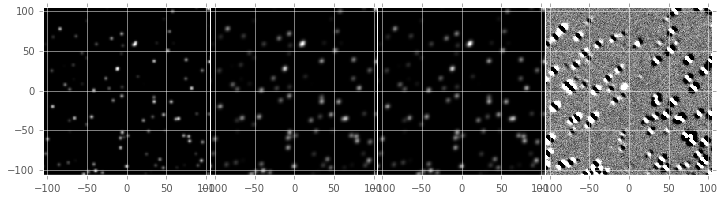

In [91]:
conv_im1 = scipy.ndimage.filters.convolve(im1, kfit, mode='constant')
print conv_im1.shape, conv_im1.min(), conv_im1.max()
print scipy.stats.describe((im2 - im1)**2, axis=None)
print scipy.stats.describe((im2 - conv_im1)**2, axis=None)

fig = plt.figure(1, (12, 3))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.0)
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
gim = igrid[0].imshow(im1[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent) # original template (red)
igrid[1].imshow(conv_im1[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent) # convolved template (blue)
igrid[2].imshow(im2[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent) # science image (dotted, purple)
igrid[3].imshow((im2 - conv_im1)[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(9,11)) # diffim (grey)
print scipy.stats.describe(im2 - conv_im1, axis=None)

Add taking into account PSF variations... (next notebook, #4)

## Compute the "L(ZOGY)" post-conv. kernel from kfit

In [ ]:
from scipy.fftpack import fft2, ifft2, fftfreq, fftshift

def kernel_ft2(kernel):
    FFT = fft2(kernel)
    return FFT
def post_conv_kernel_ft2(kernel, sig1=1., sig2=1.):
    kft = kernel_ft2(kernel)
    return np.sqrt((sig1**2 + sig2**2) / (sig1**2 + sig2**2 * kft**2))
def post_conv_kernel2(kernel, sig1=1., sig2=1.):
    kft = post_conv_kernel_ft2(kernel, sig1, sig2)
    out = ifft2(kft)
    return out

pck = post_conv_kernel2(kfit, sig1=sig2, sig2=sig1)
print kfit.shape, pck.real.shape
print pck.real.max()
print pck.real.min()
print pck.real.sum()
pck = np.fft.ifftshift(pck.real)
print np.unravel_index(np.argmax(pck), pck.shape)
extent = (x0.min()+10, x0.max()-10, y0.min()+10, y0.max()-10)
plt.imshow(pck, interpolation='none', cmap='gray', clim=(-0.04,0.05))  # this plots the matching kernel
plt.colorbar()

### I think we actually need to "reverse" the PSF, as in the ZOGY (and Kaiser) papers... let's try it.

This is the same as taking the complex conjugate in Fourier space before FFT-ing back to real space.

In [ ]:
def post_conv_kernel2a(kernel, sig1=1., sig2=1.):
    kft = post_conv_kernel_ft2(kernel, sig1, sig2)
    kft = np.conj(kft)
    out = ifft2(kft)
    return out

if False:
    pck = post_conv_kernel2a(kfit, sig1=sig2, sig2=sig1)
    print pck.real.max()
    print pck.real.min()
    print pck.real.sum()
    pck = np.fft.ifftshift(pck.real)

    # I still think we need to flip it in one axis (TBD: figure this out!)
    pck = pck[::-1,:]

    extent = (x0.min()+10, x0.max()-10, y0.min()+10, y0.max()-10)
    plt.imshow(pck, extent=extent, interpolation='none', cmap='gray', clim=(-0.04,0.05))  # this plots the matching kernel
    plt.colorbar()

## Now convolve the image difference with the kernel.

In [ ]:
print pck.sum(), pck.max(), pck.min()
#pck /= pck.sum()
pci = scipy.ndimage.filters.convolve(im2-conv_im1, pck, mode='constant')

fig = plt.figure(1, (8, 4))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.0)
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
gim = igrid[0].imshow(pci[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(im2background-1,im2background+1)) # corrected diffim
igrid[1].imshow((im2 - conv_im1)[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(im2background-1,im2background+1)) # original diffim
print scipy.stats.describe(pci, axis=None)
print scipy.stats.describe(im2 - conv_im1, axis=None)

In [ ]:
import pandas as pd
#df = pd.DataFrame({'corr': pci.flatten(), 'orig': (im2-conv_im1).flatten()})
#df.plot.hist(alpha=0.5, bins=200)

_, low, upp = scipy.stats.sigmaclip([pci, im2-conv_im1])
print low, upp
tmp1a = pci[(pci>low) & (pci<upp) & (im2-conv_im1>low) & (im2-conv_im1<upp)]
tmp2a = (im2-conv_im1)[(pci>low) & (pci<upp) & (im2-conv_im1>low) & (im2-conv_im1<upp)]
df = pd.DataFrame({'corr': tmp1a.flatten(), 'orig': tmp2a.flatten()})
df.plot.hist(alpha=0.5, bins=200)

print 'Corrected:', np.mean(tmp1a), np.std(tmp1a)
print 'Original: ', np.mean(tmp2a), np.std(tmp2a)
print 'Expected: ', np.sqrt(sig1**2 + sig2**2)

## Compute the (corrected) diffim's new PSF

In [ ]:
# post_conv_psf = phi_1(k) * sym.sqrt((sig1**2 + sig2**2) / (sig1**2 + sig2**2 * kappa_ft(k)**2))
# we'll parameterize phi_1(k) as a gaussian with sigma "psfsig1".

def kernel_ft2(kernel):
    FFT = fft2(kernel)
    return FFT
def post_conv_psf_ft2(psf, kernel, sig1=1., sig2=1.):
    psf_ft = kernel_ft2(psf)
    kft = kernel_ft2(kernel)
    out = psf_ft * np.sqrt((sig1**2 + sig2**2) / (sig1**2 + sig2**2 * kft**2))
    return out
def post_conv_psf(psf, kernel, sig1=1., sig2=1.):
    kft = post_conv_psf_ft2(psf, kernel, sig1, sig2)
    out = ifft2(kft)
    return out

# First compute the science image's (im2's) psf -- easy since we parameterized it above when we made the image
im2_psf = gaussian2d(grid, m=[0, 0], s=[psf2, psf2*1.5])

pcf = post_conv_psf(psf=im2_psf, kernel=kfit, sig1=sig2, sig2=sig1)
pcf = pcf.real / pcf.real.sum()

fig = plt.figure(1, (6, 3))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.0)
extent = (x0.min(), x0.max(), y0.min(), y0.max())
gim = igrid[0].imshow(pcf, origin='lower', interpolation='none', cmap='gray', extent=extent) #, clim=(-0.01,0.01)) # corrected psf
igrid[1].imshow(im2_psf, origin='lower', interpolation='none', cmap='gray', extent=extent) #, clim=(-0.01,0.01)) # original psf

Look at how detection would compare in the new diffim vs. the original one by convolving them with their psfs.

In [ ]:
tmp1 = scipy.ndimage.filters.convolve(pci, pcf, mode='constant')
#plt.plot(xim, tmp1)  # red - corrected
tmp2 = scipy.ndimage.filters.convolve(im2-conv_im1, im2_psf, mode='constant')
#plt.plot(xim, tmp2)  # blue - original

Detect 5-$\sigma$ sources. First compute stats on the convolved diffim's.

In [ ]:
#df = pd.DataFrame({'corr': tmp1.flatten(), 'orig': tmp2.flatten()})
#df.plot.hist(alpha=0.5, bins=200)

_, low, upp = scipy.stats.sigmaclip([tmp1, tmp2])
print low, upp
tmp1a = tmp1[(tmp1>low) & (tmp1<upp) & (tmp2>low) & (tmp2<upp)]
tmp2a = tmp2[(tmp1>low) & (tmp1<upp) & (tmp2>low) & (tmp2<upp)]
df = pd.DataFrame({'corr': tmp1a.flatten(), 'orig': tmp2a.flatten()})
df.plot.hist(alpha=0.5, bins=200)

print tmp1.std()*5., tmp2.std()*5.
print np.sum(np.abs(tmp1) > tmp1.std()*5.), np.sum(np.abs(tmp2) > tmp2.std()*5.)

import scipy.stats
tmp1a, low, upp = scipy.stats.sigmaclip(tmp1)
tmp2a, low, upp = scipy.stats.sigmaclip(tmp2)
print tmp1a.std()*5., tmp2a.std()*5.

det1 = x0im[np.abs(tmp1) > tmp1a.std()*5.]
src1 = tmp1[np.abs(tmp1) > tmp1a.std()*5.]
det2 = x0im[np.abs(tmp2) > tmp2a.std()*5.]
src2 = tmp2[np.abs(tmp2) > tmp2a.std()*5.]
if len(det1) > 0: 
    print '1:', len(det1), det1.min(), det1.max(), src1.mean(), src1.min(), src1.max()
else:
    print '1:', len(det1)
    
if len(det2) > 0:
    print '2:', len(det2), det2.min(), det2.max(), src2.mean(), src2.min(), src2.max()
else:
    print '2:', len(det2)

xaxs = np.linspace(df.min()[0], df.max()[0])
#plt.plot(xaxs, 200*gaussian(xaxs, s=tmp1a.std()), color='r')
#plt.plot(xaxs, 200*gaussian(xaxs, s=tmp2a.std()), color='b')
plt.plot(tmp1a.mean()+np.repeat(tmp1a.std()*5., 2), [-0, 5000], color='r')
plt.plot(tmp1a.mean()-np.repeat(tmp1a.std()*5., 2), [-0, 5000], color='r')
plt.plot(tmp2a.mean()+np.repeat(tmp2a.std()*5., 2), [-0, 5000], color='b')
plt.plot(tmp2a.mean()-np.repeat(tmp2a.std()*5., 2), [-0, 5000], color='b')

Dump the results for comparison with ZOGY in notebook #13.

In [ ]:
import cPickle
import gzip
im1_psf = gaussian2d(grid, m=[0, 0], s=[psf1, psf1])
#cPickle.dump((im1, im2, im1_psf, im2_psf, conv_im1, pci, pcf), gzip.GzipFile("14_results.p.gz", "wb"))